# Market Basket Analysis (MBA)

# <a name="understanding-mba">Understanding MBA</a> 
By extracting associations or co-occurrences from shop transactional databases, market basket analysis (MBA), often referred to as association-rule mining, is a helpful technique for identifying client purchasing trends (Chen et al., 2005).  This modeling technique is predicated on the idea that purchasing a particular group of goods increases or decreases your likelihood of purchasing an other group of goods. For instance, if you purchase a loaf of bread at a grocery store, you are more likely than someone who didn't purchase the bread to also purchase a packet of butter at the same time.


An itemset is the collection of products a consumer purchases, and MBA looks for connections in the itemset purchases. A set of product association rules is what the MBA produces. We can use MBA to extract interesting product association rules from transaction data that has been taken out of online retailers' shopping carts or retail stores' point of sale systems. Customers are likely to purchase product B if they purchase product A, for instance.

Usually, we are able to derive the relationship between the products as a rule. Here is an illustration of an association rule:

    IF {bread} THEN {butter}. 

In this instance, people are more likely to purchase butter if they purchase bread. High-association products are frequently associated with "complementary goods" by some people.

***
## Applications ##
There are many real-life applications of MBA:
- **Recommendation engine** - displays similar products as "Frequently bought together" or "Customers Who Bought This Item Also Bought" (as demonstrated in the above Amazon example). By examining the news items and videos that are frequently read or seen together during a user session, it can also be used to suggest news articles and videos.
<br>
<br>
- **Cross-sell / bundle products**: offering related products as a "bundle" as opposed to single ones. Transaction data can reveal, for instance, that buyers frequently purchase a screen protector along with a new phone. Retailers of phones can then increase their revenues by bundling a new phone with a high-margin screen cover and selling them together.
<br>


## Import libraries ##

In [4]:
# import the libraries required
%matplotlib inline
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore", category=DeprecationWarning)
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Load data ##

In [5]:
# load the data into a pandas dataframe and take a look at the first 10 rows
basket = pd.read_csv("BreadBasket_DMS.csv")
basket.head(10)

,Date,Time,Transaction,Item
0,30-10-2016,09:58:11,1,Bread
1,30-10-2016,10:05:34,2,Scandinavian
2,30-10-2016,10:05:34,2,Scandinavian
3,30-10-2016,10:07:57,3,Hot chocolate
4,30-10-2016,10:07:57,3,Jam
5,30-10-2016,10:07:57,3,Cookies
6,30-10-2016,10:08:41,4,Muffin
7,30-10-2016,10:13:03,5,Coffee
8,30-10-2016,10:13:03,5,Pastry
9,30-10-2016,10:13:03,5,Bread


In [6]:
# check the summary info of the dataframe
basket.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21293 entries, 0 to 21292
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Date         21293 non-null  object
 1   Time         21293 non-null  object
 2   Transaction  21293 non-null  int64 
 3   Item         21293 non-null  object
dtypes: int64(1), object(3)
memory usage: 665.5+ KB


In [7]:
basket.shape

(21293, 4)

**Note:** There are 21,293 rows and 4 columns in the dataframe. `Date` and `Time` columns are encoded in 'object' instead of Datetime, but fortunately there is a `Transaction` column which helps to identify each transaction. `Item` column contains the individual items in that transaction. For example, Transaction No. 3 contains items of "Hot chocolate", "Jam", and "Cookies" which are all transacted in the same time i.e 10.07.57 on 2016-10-30.

In [8]:
basket.describe()

,Transaction
count,21293.000000
mean,4951.990889
std,2787.758400
min,1.000000
25%,2548.000000
50%,5067.000000
75%,7329.000000
max,9684.000000


***
# Exploratory Data Analysis #

***
## Check for Missing Values ##

In [9]:
# check for missing values
basket.isnull().sum()

Date           0
Time           0
Transaction    0
Item           0
dtype: int64

In [10]:
missing_value = ["NaN", "NONE", "None", "Nil", "nan", "none", "nil", 0]
print("There are {0} missing values in the dataframe.".format(len(basket[basket.Item.isin(missing_value)])))
basket[basket.Item.isin(missing_value)].head(10)
print(basket.isna().sum())

There are 786 missing values in the dataframe.
Date           0
Time           0
Transaction    0
Item           0
dtype: int64


**Note:** While there is no empty cell in the dataframe, a check using the popular missing value shows that there are 786 rows with "NONE" in the column `Item`. Since the items are not recorded, we will have to remove these rows.

In [11]:
basket = basket.drop(basket[basket.Item == "NONE"].index)
print("Number of rows: {0}".format(len(basket)))
basket.head(10)

Number of rows: 20507


,Date,Time,Transaction,Item
0,30-10-2016,09:58:11,1,Bread
1,30-10-2016,10:05:34,2,Scandinavian
2,30-10-2016,10:05:34,2,Scandinavian
3,30-10-2016,10:07:57,3,Hot chocolate
4,30-10-2016,10:07:57,3,Jam
5,30-10-2016,10:07:57,3,Cookies
6,30-10-2016,10:08:41,4,Muffin
7,30-10-2016,10:13:03,5,Coffee
8,30-10-2016,10:13:03,5,Pastry
9,30-10-2016,10:13:03,5,Bread


**Note:** After removing the missing values, the number of rows left is 20,507 (original 21,293 minus 786 missing)

***
## Convert to DatetimeIndex ##

In [12]:
basket['Datetime'] = pd.to_datetime(basket['Date']+' '+basket['Time'])
basket = basket[["Datetime", "Transaction", "Item"]].set_index("Datetime")
basket.head(10)

,Transaction,Item
Datetime,,
2016-10-30 09:58:11,1,Bread
2016-10-30 10:05:34,2,Scandinavian
2016-10-30 10:05:34,2,Scandinavian
2016-10-30 10:07:57,3,Hot chocolate
2016-10-30 10:07:57,3,Jam
2016-10-30 10:07:57,3,Cookies
2016-10-30 10:08:41,4,Muffin
2016-10-30 10:13:03,5,Coffee
2016-10-30 10:13:03,5,Pastry


In [13]:
total_items = len(basket)
total_days = len(np.unique(basket.index.date))
total_months = len(np.unique(basket.index.month))
average_items = total_items / total_days
unique_items = basket.Item.unique().size

print("There are {} unique items sold by the Bakery".format(unique_items))
print("Total {} items sold in {} days throughout {} months".format(total_items, total_days, total_months))
print("With an average of {} items sold daily".format(average_items))


There are 94 unique items sold by the Bakery
Total 20507 items sold in 159 days throughout 12 months
With an average of 128.9748427672956 items sold daily


**Note:** We have combined the `Date` and `Time` columns into a single `Datetime` column, convert it into datetime64 type, and then set it as DatetimeIndex. This will make it easier to plot the time series charts later on. Also, a quick look at the data shows that the Bakery sold an average of 129 items daily.

***
## Visualisation ##

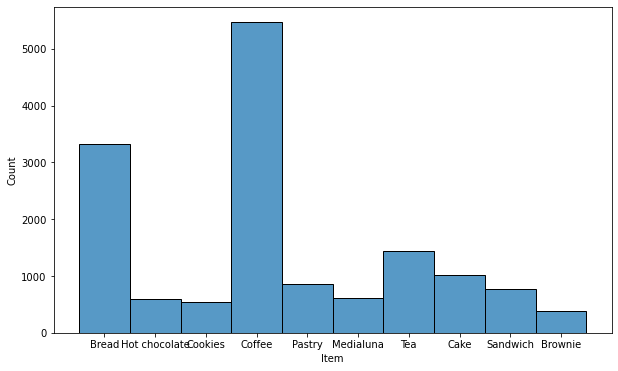

In [14]:
# Calculate the top 10 items based on some criteria, for example, the frequency of each item
top_10_items = basket['Item'].value_counts().nlargest(10).index

# Filter the DataFrame to include only the top 10 items
basket_top_10 = basket[basket['Item'].isin(top_10_items)]

# Create the histplot using seaborn
plt.figure(figsize=(10, 6))
sns.histplot(x='Item', data=basket_top_10)

plt.show()

Histogram of the top 10 items with its count is plotted. Coffee is largely purchased followed by Bread,Tea,Cake,Pastry. 

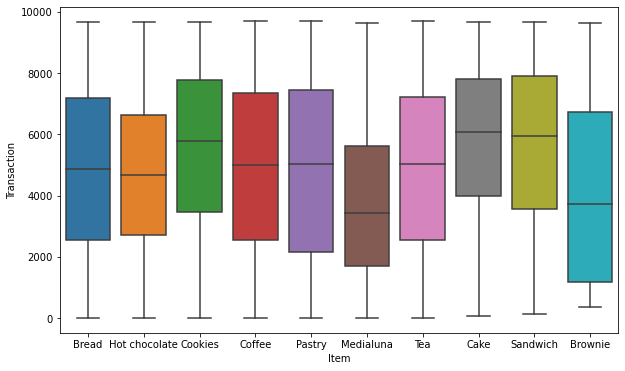

In [15]:
# Create the boxplot using seaborn
plt.figure(figsize=(10, 6))
sns.boxplot(x="Item", y='Transaction', data=basket_top_10)

plt.show()

<AxesSubplot:title={'center':'Top 20 Sales'}>

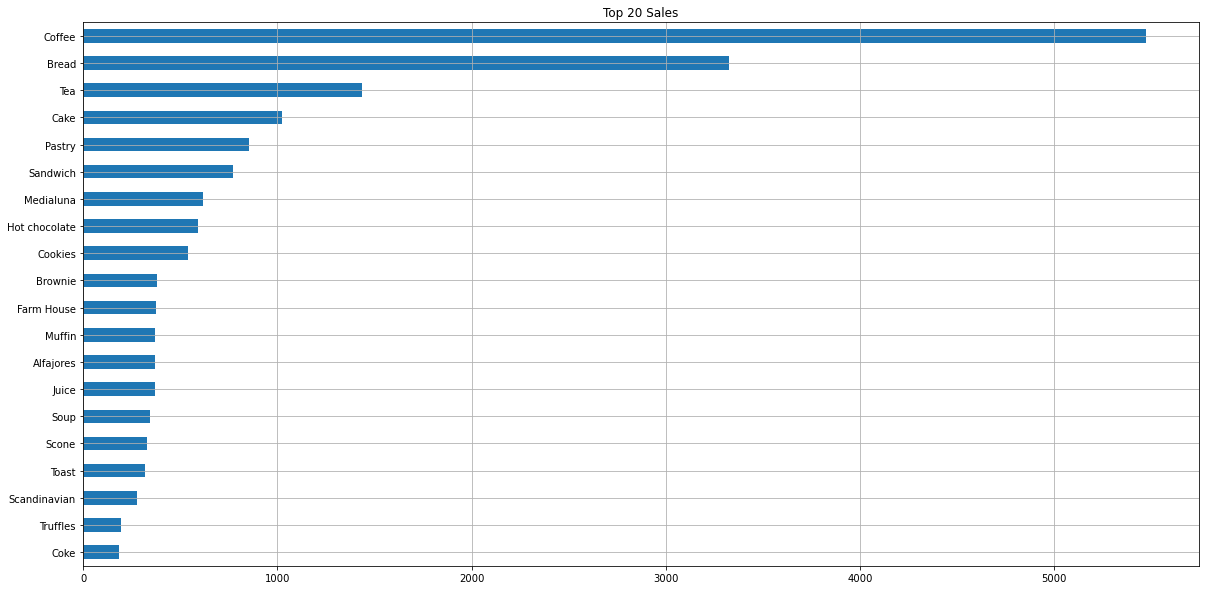

In [16]:
plt.figure(figsize=(20,10))
basket['Item'].value_counts()[:20].sort_values().plot.barh(title='Top 20 Sales',grid=True)

<AxesSubplot:title={'center':'Least 20 Sales'}>

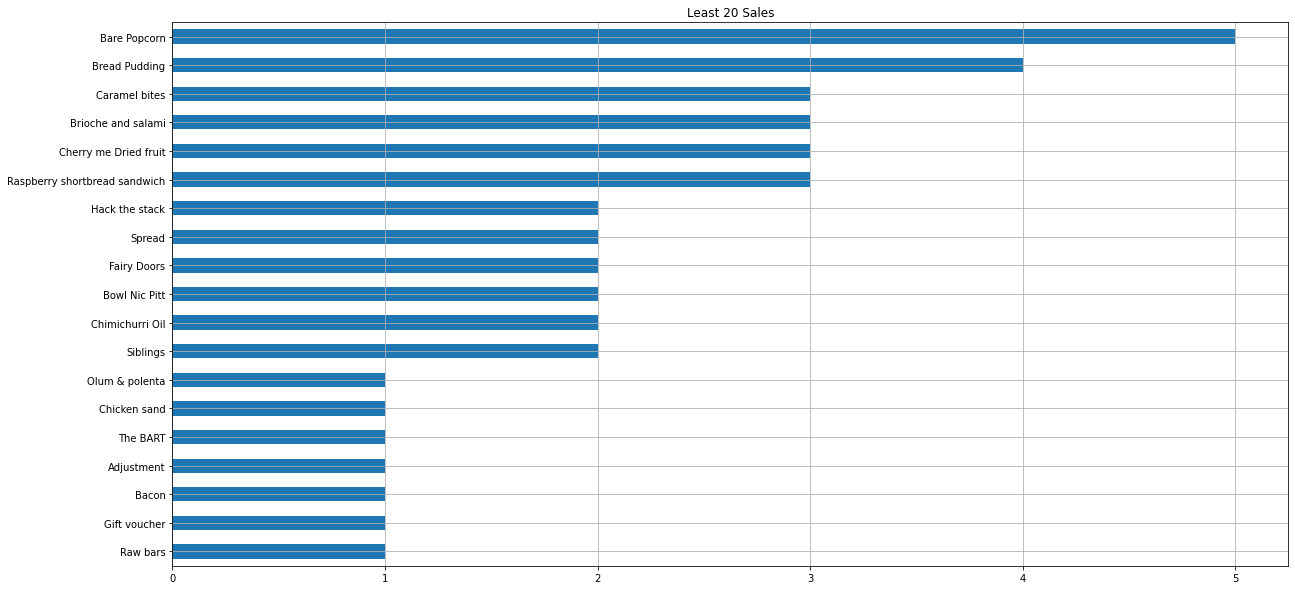

In [17]:
plt.figure(figsize=(20,10))
basket['Item'].value_counts()[-20:-1].sort_values().plot.barh(title='Least 20 Sales',grid=True)

Bare Popcorn is least purchased product followed by Bread Pudding, Caramel bites.

In [18]:
def add_datetime_features(df):
    # sleep: 12-5, 6-9: breakfast, 10-14: lunch, 14-17: dinner prep, 17-21: dinner, 21-23: deserts!
    
    df['Time'] = df.index.time
    hour = df['Time'].apply(lambda ts: ts.hour)
    df['Hour'],df['Time_Of_Day'] = hour,hour
    df['Time_Of_Day'].replace([i for i in range(0,6)], 'Sleep',inplace=True)
    df['Time_Of_Day'].replace([i for i in range(6,10)], 'Breakfast',inplace=True)
    df['Time_Of_Day'].replace([i for i in range(10,14)], 'Lunch',inplace=True)
    df['Time_Of_Day'].replace([i for i in range(14,17)], 'Dinner Prep',inplace=True)
    df['Time_Of_Day'].replace([i for i in range(17,21)], 'Dinner',inplace=True)
    df['Time_Of_Day'].replace([i for i in range(21,24)], 'Deserts',inplace=True)
    df.drop('Time',axis=1,inplace=True)
    
    df['Season'] = df.index.month
    df['Season'].replace([1,2,12], 'Winter',inplace=True)
    df['Season'].replace([i for i in range(3,6)], 'Spring',inplace=True)
    df['Season'].replace([i for i in range(6,9)], 'Summer',inplace=True)
    df['Season'].replace([i for i in range(9,12)], 'Fall',inplace=True) 
    #add_datepart(df, Datetime)
    return df

In [19]:
basket = add_datetime_features(basket)
basket.head(10)

,Transaction,Item,Hour,Time_Of_Day,Season
Datetime,,,,,
2016-10-30 09:58:11,1,Bread,9,Breakfast,Fall
2016-10-30 10:05:34,2,Scandinavian,10,Lunch,Fall
2016-10-30 10:05:34,2,Scandinavian,10,Lunch,Fall
2016-10-30 10:07:57,3,Hot chocolate,10,Lunch,Fall
2016-10-30 10:07:57,3,Jam,10,Lunch,Fall
2016-10-30 10:07:57,3,Cookies,10,Lunch,Fall
2016-10-30 10:08:41,4,Muffin,10,Lunch,Fall
2016-10-30 10:13:03,5,Coffee,10,Lunch,Fall
2016-10-30 10:13:03,5,Pastry,10,Lunch,Fall


In [20]:
basket.pivot_table(index='Season',columns='Item', aggfunc={'Item':'count'}).fillna(0)

Item                                                              \
Item   Adjustment Afternoon with the baker Alfajores Argentina Night Art Tray   
Season                                                                          
Fall          1.0                      4.0      91.0             1.0     20.0   
Spring        0.0                     14.0      54.0             1.0      3.0   
Summer        0.0                      6.0      58.0             4.0      4.0   
Winter        0.0                     20.0     166.0             1.0     11.0   

                                                    ...                     \
Item   Bacon Baguette Bakewell Bare Popcorn Basket  ... The BART The Nomad   
Season                                              ...                      
Fall     1.0     13.0     13.0          0.0    2.0  ...      0.0      12.0   
Spring   0.0     56.0     19.0          0.0    3.0  ...      1.0       9.0   
Summer   0.0     15.0      0.0          0.0    1.0  ...      0.0       8.0   
Winter   0.0     68.0     16.0          5.0    0.0  ...      0.0      29.0   

                                                                   \
Item   Tiffin  Toast Truffles Tshirt Valentine's card Vegan Feast   
Season                                                              
Fall     19.0   36.0     38.0    0.0              4.0         2.0   
Spring   48.0   91.0     57.0   21.0              5.0         4.0   
Summer   20.0   37.0     27.0    0.0              0.0         7.0   
Winter   59.0  154.0     71.0    0.0              4.0         3.0   

                                        
Item   Vegan mincepie Victorian Sponge  
Season                                  
Fall              4.0              4.0  
Spring            5.0              1.0  
Summer            3.0              1.0  
Winter           42.0              1.0  

[4 rows x 94 columns]

Text(0.5, 1.0, 'General Transation Trend Throughout The Day')

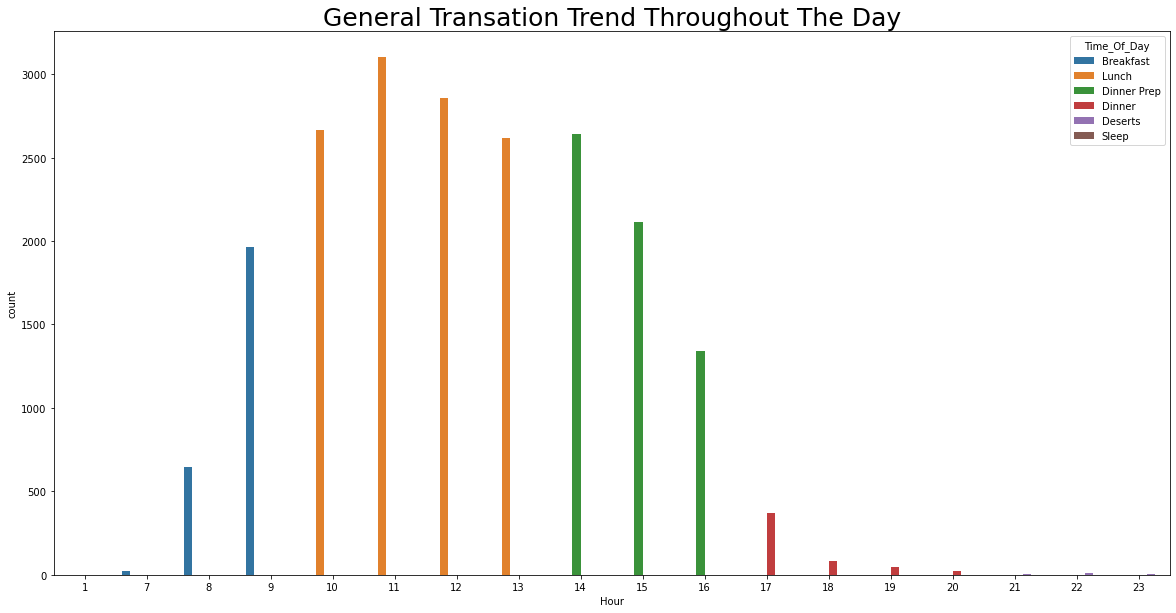

In [21]:
plt.figure(figsize=(20,10))
sns.countplot(x='Hour',data=basket,hue='Time_Of_Day').set_title('General Transation Trend Throughout The Day',fontsize=25)

From the above plot we can conclude that -
  Most of the transaction are made during Lunch. 
  Also trancsaction during Breakfast and Dinner Prep also fairly significant.

Text(0.5, 1.0, "Pattern of Transation Trend During Different Season's")

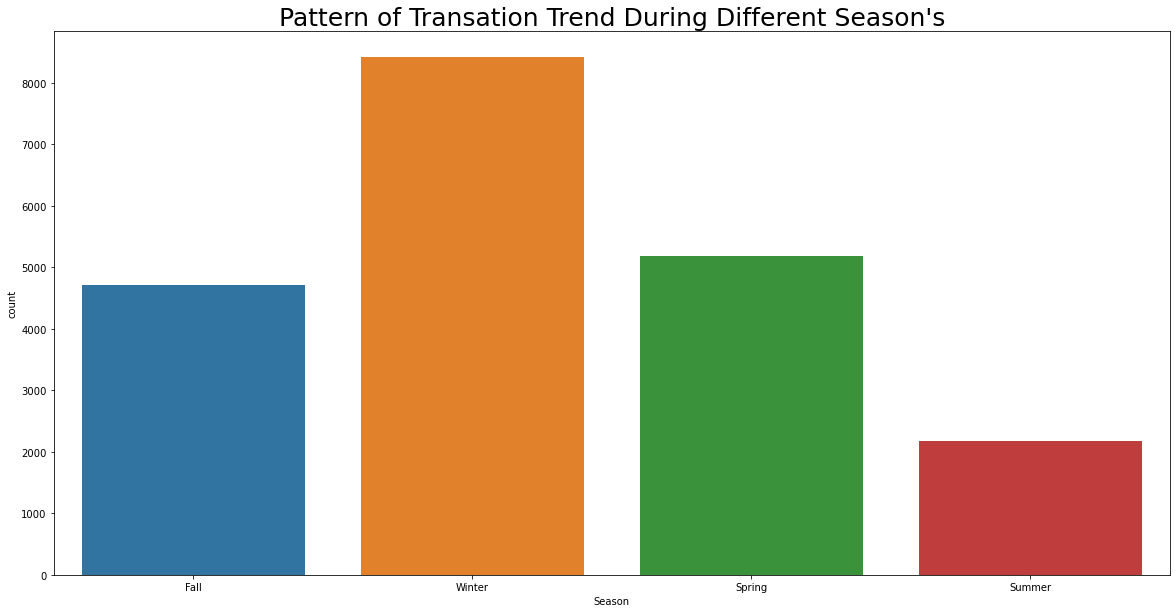

In [22]:
plt.figure(figsize=(20,10))
sns.countplot(x='Season',data=basket).set_title('Pattern of Transation Trend During Different Season\'s',fontsize=25)

[Text(0.5, 0, 'Item'), Text(0, 0.5, 'Percentage')]

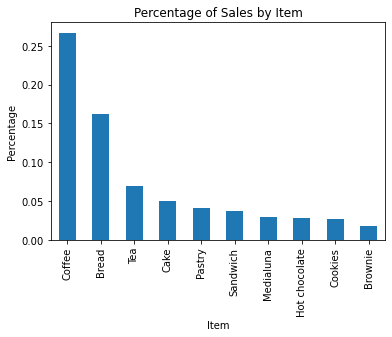

In [23]:
# create a bar chart, rank by percentage
basket.Item.value_counts(normalize=True)[:10].plot(kind="bar", title="Percentage of Sales by Item").set(xlabel="Item", ylabel="Percentage")

[Text(0.5, 0, 'Item'), Text(0, 0.5, 'Total Number')]

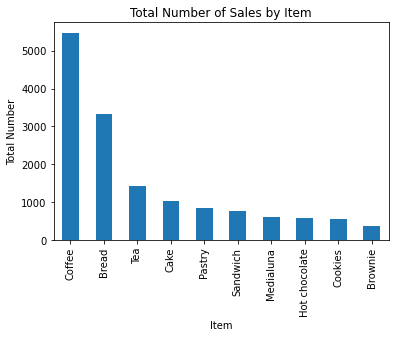

In [24]:
# create a bar chart, rank by value
basket.Item.value_counts()[:10].plot(kind="bar", title="Total Number of Sales by Item").set(xlabel="Item", ylabel="Total Number")

**Note:** From the bar charts above, it is clear that Coffee (26.7%) is the best-selling item in the bakery, follow by Bread (16.2%) and Tea (7.0%).

[Text(0.5, 0, 'Date'), Text(0, 0.5, 'Total Number of Items Sold')]

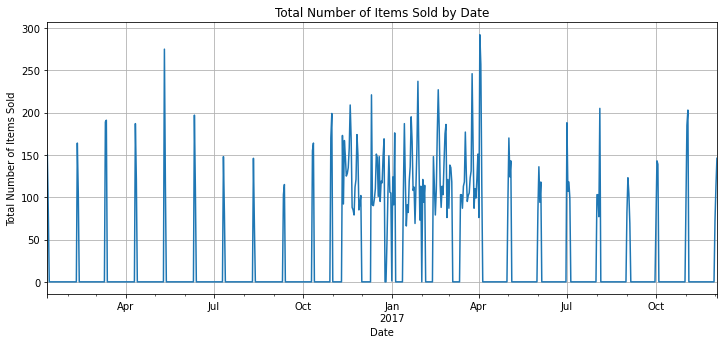

In [25]:
# plot time series chart of number of items by day
basket["Item"].resample("D").count().plot(figsize=(12,5), grid=True, title="Total Number of Items Sold by Date").set(xlabel="Date", ylabel="Total Number of Items Sold")

**Note:** Total Number of Items Sold by Date fluctuates a lot thoughout the 159 days of data

In [26]:
basket["Item"].resample("M").count()

Datetime
2016-01-31     233
2016-02-29     268
2016-03-31     380
2016-04-30     308
2016-05-31     392
2016-06-30     307
2016-07-31     229
2016-08-31     212
2016-09-30     218
2016-10-31     688
2016-11-30    2593
2016-12-31    2316
2017-01-31    2794
2017-02-28    2480
2017-03-31    2840
2017-04-30     740
2017-05-31     532
2017-06-30     432
2017-07-31     512
2017-08-31     488
2017-09-30     378
2017-10-31     353
2017-11-30     483
2017-12-31     331
Freq: M, Name: Item, dtype: int64

[Text(0.5, 0, 'Date'), Text(0, 0.5, 'Total Number of Items Sold')]

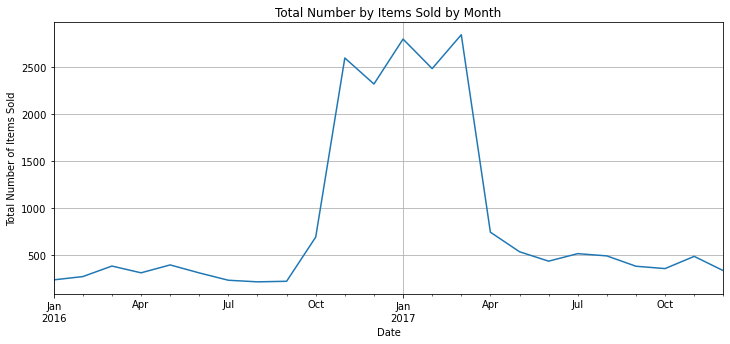

In [27]:
# plot time series chart of number of items by month
basket["Item"].resample("M").count().plot(figsize=(12,5), grid=True, title="Total Number by Items Sold by Month").set(xlabel="Date", ylabel="Total Number of Items Sold")

**Note:** Given that the beginning month (October 2016) and ending month (April 2017) are not full month, the total number of items sold by month for the five full month between November 2016 to March 2017 does not fluctuate too much.

In [28]:
# extract hour of the day and weekday of the week
# For Datetimeindex, the day of the week with Monday=0, Sunday=6, thereby +1 to become Monday=1, Sunday=7
basket["Hour"] = basket.index.hour
basket["Weekday"] = basket.index.weekday + 1

basket.head(10)

,Transaction,Item,Hour,Time_Of_Day,Season,Weekday
Datetime,,,,,,
2016-10-30 09:58:11,1,Bread,9,Breakfast,Fall,7
2016-10-30 10:05:34,2,Scandinavian,10,Lunch,Fall,7
2016-10-30 10:05:34,2,Scandinavian,10,Lunch,Fall,7
2016-10-30 10:07:57,3,Hot chocolate,10,Lunch,Fall,7
2016-10-30 10:07:57,3,Jam,10,Lunch,Fall,7
2016-10-30 10:07:57,3,Cookies,10,Lunch,Fall,7
2016-10-30 10:08:41,4,Muffin,10,Lunch,Fall,7
2016-10-30 10:13:03,5,Coffee,10,Lunch,Fall,7
2016-10-30 10:13:03,5,Pastry,10,Lunch,Fall,7


In [29]:
basket_groupby_hour = basket.groupby("Hour").agg({"Item": lambda item: item.count()/total_days})
basket_groupby_hour

,Item
Hour,
1,0.006289
7,0.150943
8,4.056604
9,12.364780
10,16.767296
11,19.509434
12,17.949686
13,16.459119
14,16.603774


[Text(0.5, 0, 'Hour of the Day (24 hour time)'),
 Text(0, 0.5, 'Average Number of Items Sold')]

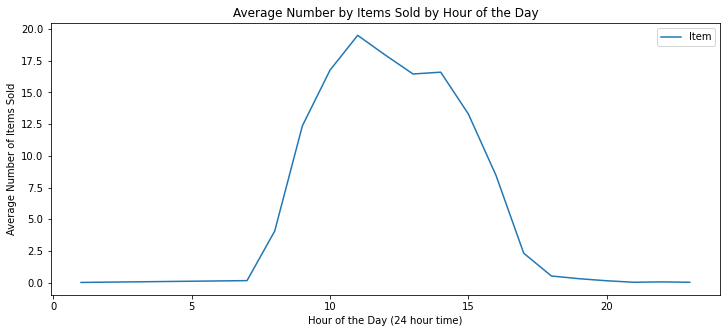

In [30]:
# plot the chart
basket_groupby_hour.plot(y="Item", figsize=(12,5), title="Average Number by Items Sold by Hour of the Day").set(xlabel="Hour of the Day (24 hour time)", ylabel="Average Number of Items Sold")

**Note:** Sales starts to pick up from 8am, till the busiest hour of the day at 11am, then slowly drops till the late afternoon. It can be observed that most of the sales transactions took place during the lunch hours of the day

In [31]:
# sales groupby weekday
basket_groupby_weekday = basket.groupby("Weekday").agg({"Item": lambda item: item.count()})
basket_groupby_weekday

,Item
Weekday,
1,3035
2,2645
3,2288
4,2601
5,3266
6,3554
7,3118


In [32]:
# but we need to find out how many each weekday in that period of transaction
# in order to calculate the average items per weekday

import datetime 
daterange = pd.date_range(datetime.date(2016, 10, 30), datetime.date(2017, 4, 9))

monday = 0
tuesday = 0
wednesday = 0
thursday = 0
friday = 0
saturday = 0
sunday = 0

for day in np.unique(basket.index.date):
    if day.isoweekday() == 1:
        monday += 1
    elif day.isoweekday() == 2:
        tuesday += 1
    elif day.isoweekday() == 3:
        wednesday += 1
    elif day.isoweekday() == 4:
        thursday += 1        
    elif day.isoweekday() == 5:
        friday += 1        
    elif day.isoweekday() == 6:
        saturday += 1        
    elif day.isoweekday() == 7:
        sunday += 1        
        
all_weekdays = monday + tuesday + wednesday + thursday + friday + saturday + sunday

print("monday = {0}, tuesday = {1}, wednesday = {2}, thursday = {3}, friday = {4}, saturday = {5}, sunday = {6}, total = {7}".format(monday, tuesday, wednesday, thursday, friday, saturday, sunday, all_weekdays))

monday = 25, tuesday = 25, wednesday = 20, thursday = 21, friday = 24, saturday = 22, sunday = 22, total = 159


In [33]:
# apply the conditions to calculate the average items for each weekday
conditions = [
    (basket_groupby_weekday.index == 1),
    (basket_groupby_weekday.index == 2),
    (basket_groupby_weekday.index == 3),
    (basket_groupby_weekday.index == 4),
    (basket_groupby_weekday.index == 5),
    (basket_groupby_weekday.index == 6),
    (basket_groupby_weekday.index == 7)]

choices = [basket_groupby_weekday.Item/21, basket_groupby_weekday.Item/23, basket_groupby_weekday.Item/23, basket_groupby_weekday.Item/23, basket_groupby_weekday.Item/23, basket_groupby_weekday.Item/23, basket_groupby_weekday.Item/23]

basket_groupby_weekday["Average"] = np.select(conditions, choices, default=0)
basket_groupby_weekday

,Item,Average
Weekday,,
1,3035,144.523810
2,2645,115.000000
3,2288,99.478261
4,2601,113.086957
5,3266,142.000000
6,3554,154.521739
7,3118,135.565217


[Text(0.5, 0, 'Day of the Week (1=Monday, 7=Sunday)'),
 Text(0, 0.5, 'Average Number of Items Sold')]

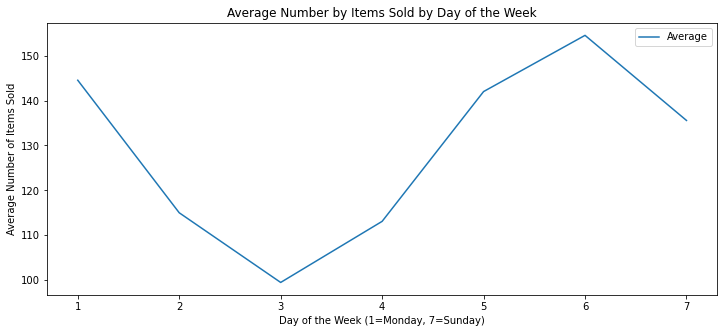

In [35]:
basket_groupby_weekday.plot(y="Average", figsize=(12,5), title="Average Number by Items Sold by Day of the Week").set(xlabel="Day of the Week (1=Monday, 7=Sunday)", ylabel="Average Number of Items Sold")

**Note:** Saturday is the busiest day of the week with the highest sales (~200 items) while Wednesday is the quietest day with the lowest sales (~101 items). This is an interesting insight, the owner of the Bakery should launch some promotion activities to boost up sales in the middle of the week when sales are slowest.

***
## One-Hot Encoding ##

The **Apriori** function in the MLxtend library expects data in a one-hot encoded pandas DataFrame. This means that all the data for a transaction must be included in one row and the items must be one-hot encoded. Example below:

|   | Coffee | Cake | Bread | Cookie | Muffin | Tea | Milk | Juice | Sandwich |
|---|--------|------|-------|--------|--------|-----|------|-------|----------|
| 0 | 0      | 1    | 1     | 0      | 0      |0    |0     |1      |0         |
| 1 | 1      | 0    | 0     | 0      | 1      |0    |0     |0      |0         |
| 2 | 0      | 0    | 0     | 1      | 0      |0    |0     |0      |1         |
| 3 | 1      | 0    | 0     | 0      | 0      |1    |0     |0      |1         |
| 4 | 1      | 1    | 0     | 0      | 0      |0    |0     |0      |0         |

Therefore, we'll need to group the basket dataframe by `Transaction` and `Item` and display the count of items. Then we need to consolidate the items into one transaction per row with each item one-hot encoded. 

In [36]:
df = basket.groupby(["Transaction","Item"]).size().reset_index(name="Count")

df.head()

,Transaction,Item,Count
0,1,Bread,1
1,2,Scandinavian,2
2,3,Cookies,1
3,3,Hot chocolate,1
4,3,Jam,1


In [37]:
basket = (df.groupby(['Transaction', 'Item'])['Count']
          .sum().unstack().reset_index().fillna(0)
          .set_index('Transaction'))

basket.head()

Item,Adjustment,Afternoon with the baker,Alfajores,Argentina Night,Art Tray,Bacon,Baguette,Bakewell,Bare Popcorn,Basket,...,The BART,The Nomad,Tiffin,Toast,Truffles,Tshirt,Valentine's card,Vegan Feast,Vegan mincepie,Victorian Sponge
Transaction,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [38]:
basket[basket.Coffee == 4].iloc[:,14:28]

Item,Brownie,Cake,Caramel bites,Cherry me Dried fruit,Chicken Stew,Chicken sand,Chimichurri Oil,Chocolates,Christmas common,Coffee,Coffee granules,Coke,Cookies,Crepes
Transaction,,,,,,,,,,,,,,
6560,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0
6850,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0
6887,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0


**Note:** At this stage, the one-hot encoded table shows the count of items purchased as result. If you observe the portion of the table above, in Transaction 6887, the cell value for Coffee is "4.0" because there were 4 coffee purchased in this transaction. However, this is not important for us and we need to convert this value into 1.

In [39]:
# the encoding function
def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1


In [40]:
basket_sets = basket.applymap(encode_units)

basket_sets.head()

Item,Adjustment,Afternoon with the baker,Alfajores,Argentina Night,Art Tray,Bacon,Baguette,Bakewell,Bare Popcorn,Basket,...,The BART,The Nomad,Tiffin,Toast,Truffles,Tshirt,Valentine's card,Vegan Feast,Vegan mincepie,Victorian Sponge
Transaction,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [41]:
basket_sets[basket_sets.Coffee == 1].iloc[3142:3145,14:28]

Item,Brownie,Cake,Caramel bites,Cherry me Dried fruit,Chicken Stew,Chicken sand,Chimichurri Oil,Chocolates,Christmas common,Coffee,Coffee granules,Coke,Cookies,Crepes
Transaction,,,,,,,,,,,,,,
6884,0,0,0,0,0,0,0,0,0,1,0,0,0,0
6885,1,0,0,0,0,0,0,0,0,1,0,0,0,0
6887,0,1,0,0,0,0,0,0,0,1,0,0,0,0


**Note:** After applying the encoding function, for the same Transaction 6887, the cell value for Coffee has become "1" which is what we need for the **Apriori** function.

***
## Generate Frequent Itemsets ##
Now, we are ready to generate the frequent item sets. We will set the minimum-support threshold at 1%


In [42]:
frequent_itemsets = apriori(basket_sets, min_support=0.01, use_colnames=True)

## Generate Association Rules ##
The final step is to generate the rules with their corresponding support, confidence and lift. We will set the minimum threshold for lift at 1 and then sort the result by descending confidence value.

In [43]:
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
rules.sort_values("confidence", ascending = False, inplace = True)
rules.head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
31,(Toast),(Coffee),0.033597,0.478394,0.023666,0.704403,1.472431,0.007593,1.764582,0.332006
29,(Spanish Brunch),(Coffee),0.018172,0.478394,0.010882,0.598837,1.251766,0.002189,1.300235,0.204851
19,(Medialuna),(Coffee),0.061807,0.478394,0.035182,0.569231,1.189878,0.005614,1.210871,0.170091
23,(Pastry),(Coffee),0.086107,0.478394,0.047544,0.552147,1.154168,0.006351,1.164682,0.146161
0,(Alfajores),(Coffee),0.036344,0.478394,0.019651,0.540698,1.130235,0.002264,1.135648,0.119574
16,(Juice),(Coffee),0.038563,0.478394,0.020602,0.534247,1.116750,0.002154,1.119919,0.108738
25,(Sandwich),(Coffee),0.071844,0.478394,0.038246,0.532353,1.112792,0.003877,1.115384,0.109205
7,(Cake),(Coffee),0.103856,0.478394,0.054728,0.526958,1.101515,0.005044,1.102664,0.102840
27,(Scone),(Coffee),0.034548,0.478394,0.018067,0.522936,1.093107,0.001539,1.093366,0.088224
13,(Cookies),(Coffee),0.054411,0.478394,0.028209,0.518447,1.083723,0.002179,1.083174,0.081700


## Interpretation and Implications ##
All of the itemsets in the output above have support values more than 1% and lift values greater than 1, and the top 10 itemsets are sorted by confidence value. With a support value of 0.023666, the association rule "if Toast then Coffee" is displayed in the first itemset. This indicates that about 2.4% of all transactions involve the purchase of both toast and coffee together. Additionally, we are 70% certain that a coffee sale will occur anytime a toast is bought. The purchase of Toast does affect the purchase of Coffee, as evidenced by the lift value of 1.47 (higher than 1), rather than the purchase of Coffee being independent of the purchase of Toast. The purchase of Toast increases the purchase of Coffee by 1.47 times, as indicated by the lift value of 1.47.

We can therefore draw the conclusion that there is evidence to support the hypothesis that buying toast precedes buying coffee. Since customers are more likely to buy coffee and toast together, the owner of "The Bread Basket" bakery should think about selling coffee and toast as a breakfast or lunch set. The staff should also be trained to cross-sell coffee to toast buyers. This will increase the store's revenue.